<a href="https://colab.research.google.com/github/lkscbrl/e-commerce/blob/main/An%C3%A1lise_de_dados_do_e_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de dados do e-commerce

Na parte anterior nós desenvolvemos uma aplicação para coletar dados do e-commerce e agora nós iremos analisa-los.

Primeiro iremos importar todas as bibliotecas necessárias:

In [1]:
import os                                                       # biblioteca utilizada para utilizar funções do sistema operacional
 
import pandas as pd                                             # principal biblioteca para trabalharmos com dados tabulares
from tabulate import tabulate                                   # utilizada para imprimir dados em formato tabular
import numpy as np                                              # utilizada para realizar operações matemáticas com vatores
import re                                                       # aplica expressões regulares para encontrar padrões no texto
 
from sklearn.feature_extraction.text import CountVectorizer     # conta o número de ocorrências para cada token e cria uma bag of words
from sklearn.feature_extraction.text import TfidfVectorizer     # calcula a importância de cada termo
from sklearn.model_selection import train_test_split            # biblioteca utilizada para repartir nossa base entre treino e teste
from sklearn.naive_bayes import GaussianNB                      # nosso classificador. utilizaremos o algorítimo naive bayes
from sklearn import metrics                                     # utilizada para calcular a performance do nosso modelo
from sklearn.metrics import confusion_matrix                    # utilizada para montar a nossa matriz de confusão
from sklearn.manifold import TSNE                               # algoritimo utlizado para decompor nossas features em componentes facilitando a visualização dos nosso dados
from sklearn.metrics.pairwise import linear_kernel              # utilizada para calcular a distância entre dois vetores

# bibliotecas utilizadas na construção de gráficos
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

Agora iremos definir algumas configurações e variáveis:

In [2]:
pd.set_option("max_colwidth", 200) # ajustamos a largura máxima das colunas de nossos dataframes

In [3]:
path = '/content/drive/MyDrive/COLAB NOTEBOOKS/PROJETOS/CATEGORIZAÇÃO DE PRODUTO DO ECOMMERCE/Dados/' # caminho onde estão nossas bases coletadas
column_names = ['product', 'brand',	'price', 'seller', 'link', 'category', 'date'] # lista com o nome das colunas de nossas bases

Listaremos todas os arquivos que coletamos com nossa aplicação e compilaremos em um único dataframe:

In [4]:
files = os.listdir(path) # lista todos os arquivos em um diretório
print(f'{len(files)} arquivo(s) encontrado(s).')

4 arquivo(s) encontrado(s).


In [5]:
def compile_df(files, path, column_names):

  df = pd.DataFrame(columns = column_names) # criamos um dataframe vazio e definimos o nome das colunas de acordo com nossa lista

  for f in files: # itera cada item do diretório
      temp = pd.read_excel(path + f) # cria um dataframe com o arquivo selecionado
      df = pd.concat([df, temp]) # concatena esse dataframe com nosso dataframe final

  df.reset_index(drop=True, inplace=True) # resetamos o índice do dataframe

  return df

In [6]:
df = compile_df(files, path, column_names)
df.head()

,product,brand,price,seller,link,category,date
0,"Smart TV LED 43"" Samsung Crystal 4K HDR UN43TU7000GXZD",Samsung,2539.84,Magazine Luiza,https://www.zoom.com.br/lead?oid=254857657&channel=1&index=0&sortorder=7&pagesize=11,/tv,07-02-2021
1,"Smart TV LED 43"" Samsung Crystal 4K HDR UN43TU7000GXZD",Samsung,2399.00,Americanas,https://www.zoom.com.br/lead?oid=215106320&channel=1&index=1&sortorder=7&pagesize=11,/tv,07-02-2021
2,"Smart TV LED 43"" Samsung Crystal 4K HDR UN43TU7000GXZD",Samsung,2199.00,Fast Shop,https://www.zoom.com.br/lead?oid=220266117&channel=1&index=2&sortorder=7&pagesize=11,/tv,07-02-2021
3,"Smart TV LED 43"" Samsung Crystal 4K HDR UN43TU7000GXZD",Samsung,2399.00,Submarino,https://www.zoom.com.br/lead?oid=215104254&channel=1&index=3&sortorder=7&pagesize=11,/tv,07-02-2021
4,"Smart TV LED 43"" Samsung Crystal 4K HDR UN43TU7000GXZD",Samsung,2199.00,Extra,https://www.zoom.com.br/lead?oid=215302275&channel=1&index=4&sortorder=7&pagesize=11,/tv,07-02-2021


# Análise exploratória

Como coletamos nossos dados através de uma aplicação desenvolvida especificamente para atender esta atividade nossos dados já estão tratados e no formato ideal, mas ainda podemos aplicar algumas análises.

In [7]:
# mostra informações do nosso dataframe como número de linhas e colunas, dados faltantes e formatos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42025 entries, 0 to 42024
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   product   42025 non-null  object 
 1   brand     42025 non-null  object 
 2   price     42025 non-null  float64
 3   seller    42025 non-null  object 
 4   link      42025 non-null  object 
 5   category  42025 non-null  object 
 6   date      42025 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.2+ MB


Vimos que não temos dados faltando e o formato de nossas colunas é adequado. Todas as colunas estão no formato `object` exceto pela coluna de preço, que está no formato `float`.

In [8]:
# nos mostra algumas estatísticas sobre nossas colunas numéricas. Também aplicável com colunas de texto
df.describe()

,price
count,42025.000000
mean,2937.264685
std,3064.121397
min,95.900000
25%,1124.910000
50%,2115.000000
75%,3689.100000
max,39999.000000


Acima vimos que o maior preço está acima de R$ 20 mil reais. Iremos verificar se esses preços estão corretos:

In [41]:
# filtramos todas as linhas com preço maior que 20000, agrupamos por produto e mostramos a média de preço
df[df['price']>=20000].groupby('product')['price'].mean() 

product
Geladeira Samsung Convert RF56K9040SR Frost Free French Door Inverse 564 Litros Inox      21199.890000
Geladeira Samsung RF265BEAESG Frost Free French Door Inverse 582 Litros Inox              25298.900000
Geladeira Samsung RF27T5501SG Frost Free French Door Inverse 614 Litros Inox              24721.860189
Macbook Apple Pro MV932 Intel Core i9 15,4" 16GB SSD 512 GB Radeon 560X Tela de Retina    32198.000000
Macbook Apple Pro MV972 Intel Core i5 13,3" 8GB SSD 512 GB Tela de Retina 8ª Geração      26899.000000
Smart TV LED 85" Sony X955G 4K XBR-85X955G 4 HDMI                                         20999.660000
Smart TV LED 86" LG ThinQ AI 4K HDR 86UN8000PSB                                           24990.000000
Smart TV OLED 77" LG ThinQ AI 4K OLED77C9PSA 4 HDMI                                       36549.990000
Smart TV QLED 75" Samsung 8K HDR QN75Q800TAGXZD 4 HDMI                                    22217.204545
Smart TV QLED 75" Samsung 8K HDR QN75Q900RBGXZD 4 HDMI           

Todos os produtos com preço acima de R$ 20 mil reais são produtos de alto padrão e estão com os preços corretos. 

# Processamento de linguagem natural

Agora iremos aplicar algumas ténicas de NLP para extrair informações relavantes da descrição dos nossos produtos.

Primeiro iremos criar uma cópia do nosso dataframe, removeremos algumas colunas e também as duplicatas, mantendo uma lista de produtos únicos:

In [10]:
df_2 = df.copy() # copia o dataframe 
df_2.drop(columns=['brand', 'price', 'seller', 'link', 'date'], inplace=True) # removemos as colunas que não nos interessa
df_2.drop_duplicates(inplace=True)  # removemos as duplicatas
df_2.reset_index(drop=True, inplace=True) # resetamos o index do dataframe
df_2.shape # imprimimos a forma do nosso novo dataframe

(1290, 2)

Em nosso novo dataframe temos apenas produtos distintos e suas respectivas categorias. Agora iremos analisar a quantidade de produtos por categoria:

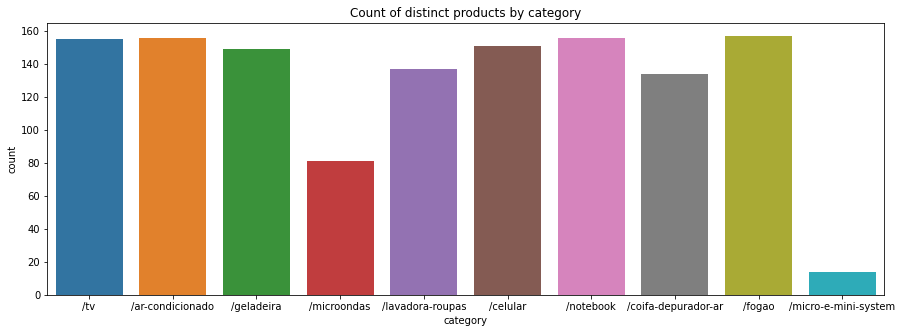

In [11]:
plt.figure(figsize=(15, 5)) # definimos o tamanho do nosso gráfico
ax = sns.countplot(x="category", data=df_2) # criamos um gráfico com a contagem de produtos por categoria
ax.set_title('Count of distinct products by category'); # definimos o título do gráfico

Vimos que nossas categorias estão balanceadas exceto por `/microondas` e `/micro-e-mini-system`. Como temos poucos exemplos para essas categorias nosso modelo poderá ter problemas para identificar os produtos dessas categorias corretamente.

# Limpeza e transformação do texto

Abaixo definiremos algumas funções para nos auxiliar no tratamento dos dados. Como nossos dados foram coletados a partir de uma plataforma tecnológica que se preocupou com a qualidade das informações contidas ali, nossos dados já estão quase no formato ideal. Iremos aplicar apenas mais algumas alterações:

In [12]:
def clean_text(text):
  # função criada para limpar e tranformar

  t_text = str(text).lower() # colocamos nossos produtos em letras minúsculas
  
  search_inches = re.search('[0-9]{1,2}"(?![a-z0-9])', t_text) # usamos uma expressão regular para identificar o símbolo de polegadas
  search_liters = re.search('[0-9]{1,3}l(?![a-z0-9])', t_text) # usamos uma expressão regular para identificar o símbolo de litros

  if search_inches is not None: # caso encontre o símbolo de polegadas(") substituímos pela palavra ' polegadas'

    t_text = re.sub(search_inches.group(), re.sub('"', ' polegadas', search_inches.group()), t_text)

  if search_liters is not None: # caso encontre o símbolo de litros(l) substituímos pela palavra ' litros'

    t_text = re.sub(search_liters.group(), re.sub('l', ' litros', search_liters.group()), t_text)

  t_text = re.sub('ar-condicionado', 'ar condicionado', t_text) # faremos uma substituíção manual do traço para não perder o sentido pois logo iremos remove-lo
  t_text = re.sub('[!@#$%^&*()_+\-=\[\]{};:"\\|<>\/?]', ' ', t_text) # removemos uma lista de caracteres especiais
  t_text = re.sub('refrigerador', 'geladeira', t_text) # faremos mais uma substituição
  t_text = ' '.join(t_text.split()) # removemos espaços duplicados

  return t_text

In [13]:
# testamos nossa função
clean_text('Refrigerador 50" ab-cde    -  10la 50l')

'geladeira 50 polegadas ab cde 10la 50 litros'

Agora aplicamos nossa função em nosso dataframe e criamos uma coluna com nossos produtos transformados:

In [14]:
df_2['cleaned_text'] = df_2['product'].apply(clean_text)

In [15]:
df_2.head()

,product,category,cleaned_text
0,"Smart TV LED 43"" Samsung Crystal 4K HDR UN43TU7000GXZD",/tv,smart tv led 43 polegadas samsung crystal 4k hdr un43tu7000gxzd
1,"Smart TV LED 43"" HQ 4K HQSTV43NY 2 HDMI",/tv,smart tv led 43 polegadas hq 4k hqstv43ny 2 hdmi
2,"Smart TV LED 43"" LG ThinQ AI Full HD HDR 43LM6300PSB",/tv,smart tv led 43 polegadas lg thinq ai full hd hdr 43lm6300psb
3,"Smart TV LED 23,6"" LG 24TL520S 2 HDMI USB",/tv,"smart tv led 23,6 polegadas lg 24tl520s 2 hdmi usb"
4,"Smart TV LED 50"" LG ThinQ AI 4K HDR 50UM7510PSB",/tv,smart tv led 50 polegadas lg thinq ai 4k hdr 50um7510psb


Após transformamos a descrição dos nosso produtos, iremos analisar quais são os temos mais recorrentes por categoria:

In [16]:
def get_top_n_words(corpus, n=None, range=1):
  # função que cria uma bag of words com a contagem de cada termo
  
  vec = CountVectorizer(ngram_range=(range, range)).fit(corpus) # ajustamos nosso vectorizer com nossos produtos transformados
  bag_of_words = vec.transform(corpus) # criamos nossa bag of words
  sum_words = bag_of_words.sum(axis=0) # contamos o número de ocorrências por palavra
  words_freq = [[word, sum_words[0, idx]] for word, idx in vec.vocabulary_.items()] # criamos uma matriz com nossas palavras e suas frequências
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True) # reordenamos para que as palavras com mais ocorrências apareçam primeiro

  return np.array(words_freq[:n]) # retorna a quantidade que solicitamos de termos e suas respectivas frequências

def plot_mostcw(df, col, n=10, range=1):
  # função para plotar um gráfico com as palavras mais frequentes por categoria

  cat = df[col].unique() # criamos uma lista com as categorias de produtos
  fig = make_subplots(rows=len(cat), cols=1, start_cell="bottom-left", subplot_titles=cat) # criamos subplots para cada categoria da lista

  for idx, c in enumerate(cat, start=1): # itera por cada categoria da lista

    common_words = get_top_n_words(df[df['category']==c]['cleaned_text'], n=n, range=range) # busca as palavras mais recorrentes por categoria utilizando a função definida acima

    fig.add_trace(go.Bar(x=common_words[:,0], y=common_words[:,1]), idx, 1) # adiciona no nosso subplot um gráfico correspondente da categoria

  fig.update_layout(title_text='Most common words by category') # definimos o título do gráfico
  fig.update_layout(showlegend=False, height=1000, width=1200,) # removemos as legendas e definimos o tamanho geral do gráfic
  fig.show() # imprimimos o gráfico

In [17]:
plot_mostcw(df_2, col='category')

Acima vimos as palavras mais frequentes por categoria. Praticamente todas as palavras são relevantes para suas respectivas categorias e não precisaremos nos preocupar com stopwords. Abaixo faremos mais uma checagem para identificar palavras que podem ser adicionadas em nossas stopwords:

In [18]:
pos_stop_words = pd.DataFrame(get_top_n_words(df_2['cleaned_text'], range=1), columns=['word', 'count']) # buscamos as palavras mais recorrentes
pos_stop_words['len'] = pos_stop_words['word'].apply(len) # criamos uma coluna com o comprimento de nossas palavras
pos_stop_words.sort_values(by='count', ascending=False, inplace=False) # ordenamos por contagem
pos_stop_words[pos_stop_words['len']==2].head(5) # filtramos nossas palavras pelo comprimento

,word,count,len
3,ar,188,2
4,de,165,2
5,tv,156,2
17,cm,135,2
28,15,103,2


Acima podemos ver que uma possível palavra para adicionarmos em nossas stopwords é a palavra `"de"`, mas como temos somente ela acredito que não teremos grandes problemas. Se tivessemos mais palavras irrelevantes para o significado da categoria teríamos que remove-las.

# TF - IDF

Agora iremos criar uma matriz a partir da nossa bag of worlds para definir quais termos são mais importantes para a nossa análise. Para isso utilizaremos um algorítimo chamado [TF - IDF (term frequency–inverse document frequency)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) definido# criamos nosso vectorizer pela fórmula:

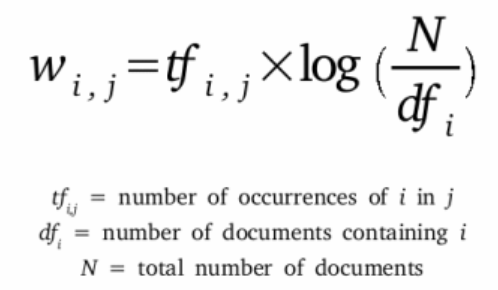

Basicamente nós calculamos a frequência de cada termo por documento e multiplicamos pela freqência inversa de todos os documentos. Sendo assim, termos que aparecem em muitos documentos terão uma relevância menor enquanto termos exclusivos de um documento e com um bom número de ocorrências terão maior importância.



In [19]:
# criamos nosso vectorizer
tfidf = TfidfVectorizer() 

# ajustamos e transformamos nossos produtos em uma matriz de termos e sua importância calculada
vec = tfidf.fit_transform(df_2['cleaned_text']).toarray() 

In [20]:
# reparem que nossa matriz tem a mesma quantidade de linhas que a quantidade inicial de produtos distintos.
# cada coluna representa um termo (palavra ou token)
vec.shape

(1290, 1860)

# Categorização de produtos

Iremos treinar nosso modelo para que seja capaz de identificar a categoria dos nosso produtos a partir de sua descrição. Nosso modelo aprenderá como distinguir cada categoria através da nossa matriz criada a partir do TF-IDF.

Primeiro precisamos de uma lista de nossas categorias:

In [21]:
categories = df_2.category.unique() # cria uma lista com cada uma das noas categorias

In [22]:
encode = dict((j,i) for i,j in enumerate(categories)) # enumeramos nossas categorias pois nosso categorizador irá trabalhar com números apenas
encode

{'/ar-condicionado': 1,
 '/celular': 5,
 '/coifa-depurador-ar': 7,
 '/fogao': 8,
 '/geladeira': 2,
 '/lavadora-roupas': 4,
 '/micro-e-mini-system': 9,
 '/microondas': 3,
 '/notebook': 6,
 '/tv': 0}

In [23]:
y = df_2.category.map(encode) # codificamos nossas categorias do dataframe por seu respectivo número
y[:5]

0    0
1    0
2    0
3    0
4    0
Name: category, dtype: int64

In [24]:
# separamos nossa base de dados entre base de treino e base de teste com uma proporção de 30% para teste e o restante para treino
X_train, X_test, y_train, y_test = train_test_split(vec, y, test_size=0.3, random_state=11)

In [42]:
model = GaussianNB() # criamos nossa classificador
                     # O algorítmo escolhido é o naive bayes que aplica o teorema de bayes para calcular a categoria mais provável

model.fit(X_train, y_train) # treinamos nosso modelo com nossas bases de treino

GaussianNB(priors=None, var_smoothing=1e-09)

In [26]:
y_pred = model.predict(X_test) # aplicamos nosso modelo para tentar descobrir a categoria dos produtos da nossa base de teste

In [27]:
y_pred # abaixo uma lista das categorizações feitas. As categorias estão codificadas conforme definimos acima

array([0, 7, 7, 5, 4, 1, 7, 8, 0, 3, 5, 2, 4, 6, 0, 6, 6, 7, 8, 8, 1, 8,
       0, 3, 4, 5, 2, 2, 3, 2, 8, 0, 6, 8, 8, 6, 2, 4, 6, 7, 1, 7, 7, 8,
       0, 1, 5, 1, 0, 8, 2, 7, 7, 7, 7, 2, 7, 7, 1, 4, 4, 1, 0, 2, 7, 1,
       2, 4, 8, 5, 2, 1, 2, 1, 6, 7, 1, 4, 8, 5, 5, 0, 5, 7, 7, 1, 1, 4,
       1, 4, 5, 0, 5, 5, 3, 8, 8, 0, 4, 2, 0, 0, 0, 3, 0, 5, 0, 3, 7, 8,
       1, 8, 0, 4, 0, 0, 5, 2, 0, 0, 8, 7, 7, 6, 0, 2, 0, 2, 3, 0, 8, 4,
       5, 8, 1, 1, 6, 5, 5, 6, 4, 2, 4, 5, 4, 0, 0, 5, 6, 6, 7, 8, 6, 4,
       2, 1, 8, 0, 0, 5, 5, 2, 7, 2, 6, 2, 6, 6, 6, 5, 1, 0, 7, 5, 0, 0,
       0, 0, 2, 7, 0, 5, 8, 2, 7, 2, 7, 6, 8, 8, 8, 8, 7, 7, 7, 0, 7, 0,
       4, 8, 2, 5, 1, 6, 1, 8, 6, 8, 2, 1, 7, 8, 5, 8, 6, 7, 6, 0, 6, 2,
       5, 5, 1, 2, 5, 2, 8, 7, 6, 2, 3, 4, 2, 3, 1, 5, 6, 8, 7, 4, 7, 2,
       4, 7, 2, 3, 6, 8, 3, 5, 7, 2, 0, 1, 6, 4, 1, 7, 2, 5, 5, 4, 8, 4,
       1, 5, 9, 7, 2, 2, 7, 6, 8, 5, 0, 6, 1, 4, 4, 1, 6, 4, 2, 8, 1, 1,
       1, 6, 3, 1, 4, 4, 4, 6, 2, 6, 0, 4, 8, 4, 2,

Agora iremos checar a acurácia do nosso modelo:

In [28]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)) # mostramos a acurácia de nosso modelo

Accuracy: 0.9948320413436692


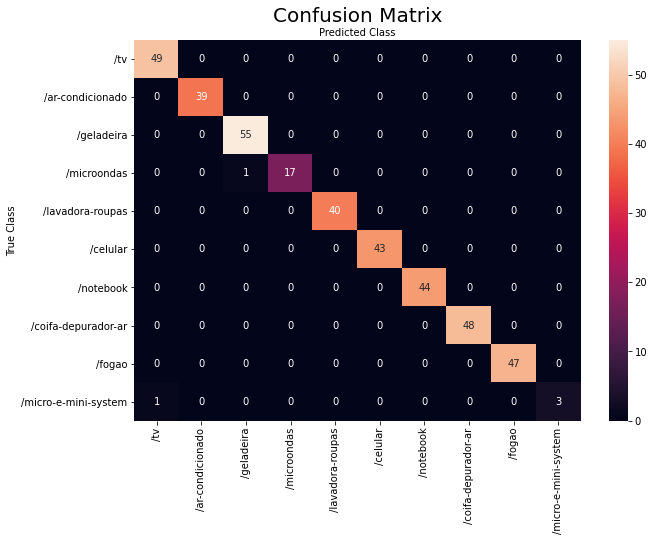

In [29]:
cm = confusion_matrix(y_test, y_pred) # criamos uma matriz de confusão

df_cm = pd.DataFrame(cm, index = [i for i in categories],
                  columns = [i for i in categories]) # criamos um dataframe a partir da nossa matriz de confusão para facilitar a visualização

f, ax = plt.subplots(figsize=(10, 7)) # criamos um subplot

sns.heatmap(df_cm, annot=True, fmt="d") # criamos um mapa de calor para a nossa matriz
ax.set_title('Confusion Matrix', fontsize = 20) # definimos o título e o tamanho da fonte
ax.set_ylabel('True Class') # definimos o rótulo do eixo y que indica nossa classe verdadeira
ax.set_xlabel('Predicted Class') # definimos o rótulo do eixo x que indica nossa classe estimada
ax.xaxis.set_label_position('top') # movemos o rótulo do eixo x para a parte superior do gráfico

## Ual! nossa acurácia está em quase 100% e em nossa matriz de confusão identificamos apenas 2 erros... isso está estranho!

Normalmente isso indicaria que nosso modelo teve um sobreajuste, ou seja, ele decorou nossos dados e perdeu a capacidade de generalizar, entretanto, nosso modelo está funcionando sim muito bem. 

O motivo dessa excelente performance se dá pela qualidade dos dados, que desde o processo da coleta foram trabalhados para atender nossas análises, além de que as categorias de produtos análisados são muito distintas, possuindo palavras exclusivas, que evidentemente nosso vetorizador TF-IDF atribuiu uma grande importância, fazendo com que seja mais fácil de identificar a categoria correta.

Os erros observados foram nas nossas duas categorias com menor número de produtos distintos, e como prevemos anteriormente, nosso modelo teve mais dificuldade de identifica-las.

Para entender melhor como nosso modelo conseguiu funcionar tão bem, iremos utilizar um algorítimo chamado TSNE para visualizar a distribuição espacial dos nossos produtos. 

Basicamente, o [TSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) decompõe nossos atributos, que nesse caso são nossas colunas para cada termo(palavra/token), em componentes que explicam nossos dados. Dessa forma conseguimos diminuir nossas colunas, que são milhares, para 3 componentes para que possamos plotar a posição de cada produto em um gráfico 3D.



In [30]:
tsne = TSNE(n_components=3).fit_transform(vec) # a partir da nossa matriz tf-idf decompomos nossos 3 componentes

In [31]:
# plotamos nossos componentes
# definimos nossas legendas para categoria
# cada ponto representa um produto
fig = px.scatter_3d(
    tsne, x=0, y=1, z=2,
    color=df_2.category, labels={'color': 'category'}, hover_name=df_2.cleaned_text, title='TSNE Visualization')

fig.update_traces(marker_size=8) # definimos o tamanho dos pontos
fig.show() # exibimos o gráfico

# OBS: o gráfico abaixo permite interação, podendo ser rotacionado.

Como vimos acima, nossas categorias estão bem separadas, permitindo distinguir facilmente a qual categoria cada produto pertence. Dessa forma, justificamos a acurácia do nosso modelo.

# Aplicação

Para finalizarmos, iremos desenvolver uma aplicação que simula um buscador de produtos. O usuário irá inserir uma breve descrição do produto que tem interesse e iremos apresentar as principais ofertas relacionadas.

Abaixo criaremos um catálogo de produtos, com todas nossas ofertas:

In [32]:
catalog = df.copy() # criamos uma cópia do nosso dataframe original
catalog.sort_values(by='date', inplace=True, ignore_index=True, ascending=False) # ordenamos nossas ofertas por data, para apresentarmos as mais recentes
catalog.drop(columns=['date'], inplace=True) # removemos a coluna de data
catalog.drop_duplicates(subset=['product', 'seller'], inplace=True) # removemos as duplicatas por produto e vendedor
catalog.head()

,product,brand,price,seller,link,category
0,Depurador de Ar Parede Fischer 60 cm Classic Power 60cm,Fischer,420.90,Mercado Livre,https://www.zoom.com.br/lead?oid=330589794&channel=1&index=8&sortorder=7&pagesize=36,/coifa-depurador-ar
1,Micro-ondas Philco 26 Litros PMO26I,Philco,682.21,Magazine Luiza,https://www.zoom.com.br/lead?oid=309867894&channel=1&index=0&sortorder=7&pagesize=13,/microondas
2,Micro-ondas Panasonic Style 30 Litros NN-GT684SRUK Inox,Panasonic,899.90,Casas Bahia,https://www.zoom.com.br/lead?oid=249734865&channel=1&index=3&sortorder=7&pagesize=6,/microondas
3,Micro-ondas Panasonic Style 30 Litros NN-GT684SRUK Inox,Panasonic,869.56,Extra,https://www.zoom.com.br/lead?oid=329368299&channel=1&index=2&sortorder=7&pagesize=6,/microondas
4,Micro-ondas Panasonic Style 30 Litros NN-GT684SRUK Inox,Panasonic,869.56,Pontofrio,https://www.zoom.com.br/lead?oid=329359364&channel=1&index=1&sortorder=7&pagesize=6,/microondas


Agora definiremos nossas funções:

In [33]:
def find_category(input, model=model, categories=encode):
  # aplica nosso categorizador para identificar a categoria do produto inserido pelo usuário

  return list(categories.keys())[model.predict(input.toarray()).item()] # simplesmente retorna a categoria

def find_products(input, vec=vec, df=df_2, catalog=catalog):
  # procura produtos similares de acordo com a descrição dada pelo usuário

  product_vec = tfidf.transform([clean_text(input)]) # transforma a descrição informada a partir do nosso vetorizador tf-idf
  cosine_similarities = linear_kernel(product_vec, vec).flatten() # calcula a distancia do cosseno entre o produto procurado e cada item da nossa lista de produtos
  document_scores = [item.item() for item in cosine_similarities] # cria uma lista com o score de similaridade de cada produto da nossa base

  df['score'] = document_scores # adiciona uma coluna em nosso dataframe com o score de cada produto
  df = df[df['score']>=0.5] # filtramos somente produtos com um score acima de 0.5, previnindo que sejam mostrados produtos irrelevantes
  df = df.nlargest(5, 'score') # selecionamos os 5 produtos mais relevantes
  df = df.merge(catalog.drop(columns='category'), on='product') # selecionamos em nosso catálogo todas as promoções relacionadas a esses produtos mais relevantes
  df.drop(columns=['category', 'cleaned_text', 'score'], inplace=True) # removemos algumas colunas

  category = find_category(product_vec) # aplicamos nosso categorizador para identificar a categoria do produto

  return df, category # retornamos um dataframe com nossas promoções e a categoria do produto

Abaixo o usuário consegue colocar uma breve descrição do produto que tem interesse. Logo em seguida mostramos nossas ofertas relevantes:

In [34]:
search = "micro-ondas panasonic 21 litros" #@param {type:"string"}
df_3, category = find_products(search) # aplica nossa função

print(f'Showing similar products from the category "{category}":')
print(tabulate(df_3, headers = 'keys', tablefmt = 'psql',
               floatfmt='.2f', showindex=False)) # imprime nossas promoções em formato tabular

Showing similar products from the category "/microondas":
+---------------------------------------------+-----------+---------+----------------+--------------------------------------------------------------------------------------+
| product                                     | brand     |   price | seller         | link                                                                                 |
|---------------------------------------------+-----------+---------+----------------+--------------------------------------------------------------------------------------|
| Micro-ondas Panasonic 21 Litros ST25LWRU    | Panasonic |  539.10 | Carrefour      | https://www.zoom.com.br/lead?oid=295172802&channel=1&index=6&sortorder=7&pagesize=19 |
| Micro-ondas Panasonic 21 Litros ST25LWRU    | Panasonic |  489.00 | Pontofrio      | https://www.zoom.com.br/lead?oid=278449471&channel=1&index=4&sortorder=7&pagesize=19 |
| Micro-ondas Panasonic 21 Litros ST25LWRU    | Panasonic |  489.90 | Sh

Caso o usuário não encontre nenhuma promoção interessante iremos mostrar as promoções com os menores preços da categoria:

In [35]:
print(f'Did not find what you were looking for? see the main offers for the category "{category}":')
df_4 = catalog.copy() # criamos uma cópia do nosso catálogo
df_4 = df_4[df_4['category']==category] # filtramos as ofertas da categoria desejada
df_4.drop(columns='category', inplace=True) # removemos a coluna de categoria
df_4.sort_values(by='price', inplace=True) # ordenamos pela coluna de preço para mostrar os produtos mais baratos primeiro
df_4.drop_duplicates('product') # removemos as duplicatas por produto
print(tabulate(df_4.head(10), headers = 'keys', tablefmt = 'psql', floatfmt='.2f', showindex=False)) # apresentamos as 10 primeiras oferas em formato tabular

Did not find what you were looking for? see the main offers for the category "/microondas":
+----------------------------------------+------------+---------+---------------+--------------------------------------------------------------------------------------+
| product                                | brand      |   price | seller        | link                                                                                 |
|----------------------------------------+------------+---------+---------------+--------------------------------------------------------------------------------------|
| Micro-ondas Britânia 26 Litros Bmm26b  | Britânia   |  386.10 | Carrefour     | https://www.zoom.com.br/lead?oid=273856553&channel=1&index=7&sortorder=7&pagesize=29 |
| Micro-ondas Britânia 26 Litros Bmm26b  | Britânia   |  386.65 | Shoptime      | https://www.zoom.com.br/lead?oid=231758202&channel=1&index=3&sortorder=7&pagesize=29 |
| Micro-ondas Midea 20 Litros MTFE2      | Midea      |  389.00

# Conclusão

Nem sempre teremos a sorte de trabalhar com textos tão bem estruturados, mas ainda assim nossa aplicação poderá ser aplicada a problemas mais complexos com os devidos ajustes. 